# Установка библиотек и загрузка данных

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from itertools import product
import datetime
import os

# Для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Осмотр данных

In [3]:
df = pd.read_csv('ped_crashes.csv')

print("\nИнформация о датасете:")
print(df.info())
print(df.describe())
print(f"Количество строк: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1] - 1} (плюс 1 целевая переменная)")
print(f"Целевая переменная: 'Worst Injury in Crash'")
print(f"Уникальных классов: {df['Worst Injury in Crash'].nunique()}")
print(f"Классы: {sorted(df['Worst Injury in Crash'].unique())}")


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6809 entries, 0 to 6808
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Crash Year                  6809 non-null   int64 
 1   Crash Month                 6809 non-null   object
 2   Crash Day                   6809 non-null   int64 
 3   Time of Day                 6809 non-null   object
 4   Day of Week                 6809 non-null   object
 5   City or Township            6809 non-null   object
 6   Crash: Intersection         6809 non-null   object
 7   Crash: Hit-and-Run          6809 non-null   object
 8   Lighting Conditions         6809 non-null   object
 9   Weather Conditions (2016+)  6809 non-null   object
 10  Speed Limit at Crash Site   6809 non-null   object
 11  Worst Injury in Crash       6809 non-null   object
 12  Party Type                  6809 non-null   object
 13  Person Age              

## Разбиение данных

In [4]:
le = LabelEncoder()
y = le.fit_transform(df['Worst Injury in Crash'])

X = df.drop('Worst Injury in Crash', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Форматирование данных

In [5]:
numeric_features = [
    'Crash Year', 
    'Crash Day',
]
categorical_features = [
    'Crash Month', 'Time of Day', 
    'Day of Week', 'City or Township',
    'Crash: Intersection', 'Crash: Hit-and-Run',
    'Lighting Conditions', 'Weather Conditions (2016+)',
    'Speed Limit at Crash Site',
    'Party Type', 'Person Age', 'Person Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Функция оценки модели

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, plot_cm=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    if y_proba is not None:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')
    else:
        auc = np.nan
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Визуализация матрицы ошибок
    if plot_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_train),
                    yticklabels=np.unique(y_train))
        plt.title(f'Confusion Matrix — {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    }

# Наивный байесовский классификатор (GaussianNB)
Основа: Теорема Байеса с предположением условной независимости признаков при заданном классе («наивность»).
GaussianNB — частный случай для непрерывных признаков, предполагающих нормальное (гауссово) распределение внутри каждого класса.

Плюсы:

* Быстрый, простой, требует мало данных для обучения.
* Хорошо работает при малом количестве признаков и при высокой размерности (например, в текстовой классификации).

Минусы:

* Реальное независимое распределение признаков — редкость → может давать смещённые оценки вероятностей.
* Чувствителен к коррелированным признакам.

train_scores: [0.0803468  0.08258197 0.08602296 0.09092784 0.09339445 0.10323926
 0.11391678 0.13462457 0.17401374 0.25290074 0.31268824 0.32794092
 0.19568564] 
val_scores:[0.05235339 0.05338403 0.05543871 0.05619654 0.0609854  0.06626417
 0.07227759 0.08789702 0.11668875 0.17669979 0.23466867 0.28737784
 0.19568563]
Лучший var_smoothing: 1.00e-01, F1 score 0.2874


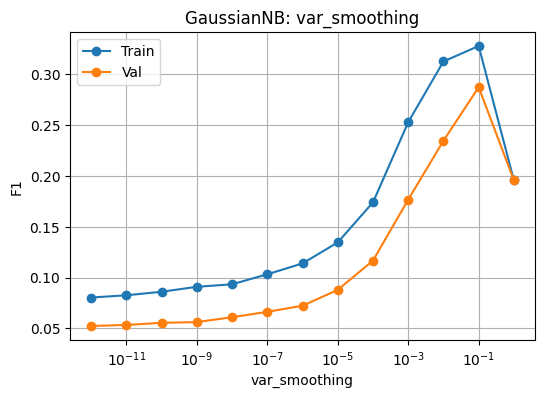

[[ 43  14  38   7   1]
 [ 15  54 122   7   0]
 [ 28 112 338  16   4]
 [ 42  63 200  39   2]
 [ 39  43 110  18   7]]


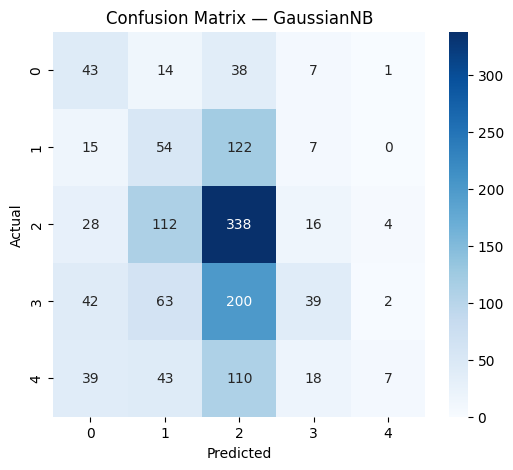

In [7]:
results = []

# Создаем пайплайн с ИСПРАВЛЕННЫМ preprocessor
gnb_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', GaussianNB())])

# Диапазон гиперпараметра
var_smoothing_range = np.logspace(-12, 0, 13)

# Валидационная кривая
train_scores, val_scores = validation_curve(
    gnb_pipe, X_train, y_train,
    param_name='classifier__var_smoothing',
    param_range=var_smoothing_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

# Поиск лучшего параметра
best_idx = np.argmax(np.mean(val_scores, axis=1))
best_var_smoothing = var_smoothing_range[best_idx]
print(f"train_scores: {np.mean(train_scores, axis=1)} \nval_scores:{np.mean(val_scores, axis=1)}\nЛучший var_smoothing: {best_var_smoothing:.2e}, F1 score {max(np.mean(val_scores, axis=1)):.4f}")

# Финальная модель с лучшим параметром
gnb_best = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB(var_smoothing=best_var_smoothing))
])

# Визуализация
plt.figure(figsize=(6, 4))
plt.semilogx(var_smoothing_range, np.mean(train_scores, axis=1), 'o-', label='Train')
plt.semilogx(var_smoothing_range, np.mean(val_scores, axis=1), 'o-', label='Val')
plt.xlabel('var_smoothing')
plt.ylabel('F1')
plt.title('GaussianNB: var_smoothing')
plt.legend()
plt.grid()
plt.show()

# Оценка на тестовой выборке
# Убедитесь, что функция evaluate_model определена корректно выше
results.append(evaluate_model(gnb_best, X_train, X_test, y_train, y_test, 'GaussianNB'))

Результаты показывают, что модель GaussianNB (наивный Байес) справляется с задачей крайне слабо. Значение F1-score = 0.2874 — это очень низкий показатель, который говорит о том, что модель часто ошибается и плохо разделяет классы травм. GaussianNB предполагает, что признаки распределены по нормальному (Гауссову) закону и независимы друг от друга. В данных о ДТП (погода, время суток, освещение) это почти никогда не так — признаки сильно взаимосвязаны.

Также наблюдается сильное недообучение (rain_scores = 0.32 и val_scores = 0.28). Разрыв между ними невелик, но оба значения очень низкие. Это классический Underfitting: модель слишком проста для этих данных. Она не может "уловить" сложные закономерности в причинах травм, сколько бы данных вы ей ни дали.

График и данные показывают, что лучший результат достигается при $var\_smoothing = 1.00e-01$ ($0.1$). Этот параметр добавляет "сглаживание" (часть дисперсии всех признаков) к расчетной дисперсии, чтобы стабилизировать расчеты. То, что лучший результат на самом краю диапазона (0.1), намекает на то, что модель пытается хоть как-то "размыть" свои слишком жесткие предположения о данных.

Последнее значение в списках (0.19) резко падает после пика. Это означает, что при слишком большом сглаживании ($var\_smoothing = 1$) модель становится "слишком простой" и начинает игнорировать различия в данных, превращаясь в "константное" предсказание.

Глядя матрицу, можно сказать, что модель находится в состоянии сильного замешательства. Она не просто ошибается, она практически не различает классы между собой. Центральный элемент 338 (пересечение 3-й строки и 3-го столбца) — самое большое число. Это говорит о том, что модель классифицирует большинство аварий как среднюю категорию (вероятно, «Possible injury» или «No injury»). Происходит огромное количество ложных срабатываний: 38, 122, 200, 110. Это значит, что для огромного количества ДТП с другими исходами (включая, возможно, тяжелые) модель ошибочно предсказала этот «средний» класс. Особенно критично значение 110 в левом нижнем углу: модель видит смертельный исход, но считает его чем-то незначительным.

Так же в хорошей модели самые большие числа должны быть на главной диагонали (слева сверху — вправо снизу). Однако в последней строке всего 7 правильных предсказаний против 210 ошибок. То есть вероятность того, что модель правильно определит этот класс, составляет всего около 3%.

GaussianNB пытается провести «границы» между классами, полагая, что данные распределены кучно. Но данные о ДТП (погода, возраст, время) сильно перемешаны. Для модели авария в дождь при 40 км/ч выглядит почти так же, как авария в снег при 40 км/ч, хотя последствия могут быть разными.

## Деревья решений (Decision Tree)
Основа: Рекурсивное разбиение пространства признаков на подмножества (узлы), максимизируя чистоту (например, по критерию Джини или энтропии).

Плюсы:

* Интерпретируемость (можно визуализировать дерево).
* Не требует масштабирования признаков, устойчив к выбросам.
* Автоматически выявляет важные признаки и взаимодействия между ними.

Минусы:

* Склонны к переобучению (особенно при глубоких деревьях).
* Нестабильны: небольшие изменения в данных → совсем другое дерево

Исследование max_depth:
max_depth=3: F1 = 0.2625
max_depth=5: F1 = 0.2941
max_depth=10: F1 = 0.3041
max_depth=15: F1 = 0.3184
max_depth=20: F1 = 0.3314
max_depth=25: F1 = 0.3239
max_depth=30: F1 = 0.3207
max_depth=None: F1 = 0.3232

Исследование min_samples_split:
min_samples_split=2: F1 = 0.3232
min_samples_split=5: F1 = 0.3176
min_samples_split=10: F1 = 0.3196
min_samples_split=15: F1 = 0.3109
min_samples_split=20: F1 = 0.3147
min_samples_split=30: F1 = 0.3101

Исследование min_samples_leaf:
min_samples_leaf=1: F1 = 0.3232
min_samples_leaf=2: F1 = 0.3098
min_samples_leaf=3: F1 = 0.3113
min_samples_leaf=5: F1 = 0.3107
min_samples_leaf=7: F1 = 0.3079
min_samples_leaf=10: F1 = 0.3048

Исследование критериев:
criterion=gini: F1 = 0.3232
criterion=entropy: F1 = 0.3262


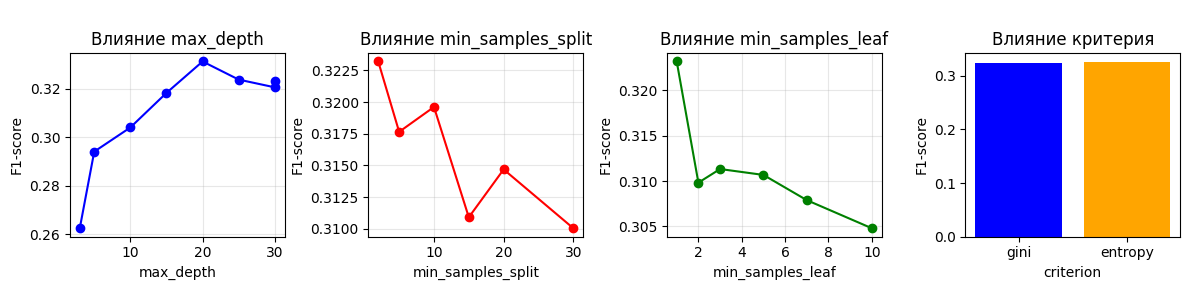


Финальная настройка Decision Tree
Лучшие параметры DT: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучший F1-score: 0.3368
[[ 31  13  22  22  15]
 [  8  26  92  50  22]
 [ 19  70 224 104  81]
 [ 16  43 135 110  42]
 [ 12  26  82  43  54]]


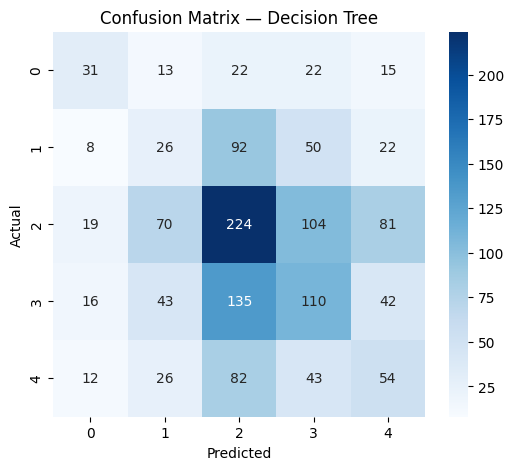

In [8]:
print("Исследование max_depth:")
max_depths = [3, 5, 10, 15, 20, 25, 30, None]
depth_results = []

for depth in max_depths:
    dt_temp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    depth_results.append(f1)
    print(f"max_depth={depth}: F1 = {f1:.4f}")


print("\nИсследование min_samples_split:")
min_splits = [2, 5, 10, 15, 20, 30]
split_results = []

for min_split in min_splits:
    dt_temp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(min_samples_split=min_split, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    split_results.append(f1)
    print(f"min_samples_split={min_split}: F1 = {f1:.4f}")


print("\nИсследование min_samples_leaf:")
min_leaves = [1, 2, 3, 5, 7, 10]
leaf_results = []

for min_leaf in min_leaves:
    dt_temp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    leaf_results.append(f1)
    print(f"min_samples_leaf={min_leaf}: F1 = {f1:.4f}")


print("\nИсследование критериев:")
criteria = ['gini', 'entropy']
criterion_results = []

for criterion in criteria:
    dt_temp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(criterion=criterion, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    criterion_results.append(f1)
    print(f"criterion={criterion}: F1 = {f1:.4f}")


plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.plot([d if d else 30 for d in max_depths], depth_results, 'bo-')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.title('\nВлияние max_depth')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 2)
plt.plot(min_splits, split_results, 'ro-')
plt.xlabel('min_samples_split')
plt.ylabel('F1-score')
plt.title('\nВлияние min_samples_split')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 3)
plt.plot(min_leaves, leaf_results, 'go-')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.title('\nВлияние min_samples_leaf')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 4)
plt.bar(criteria, criterion_results, color=['blue', 'orange'])
plt.xlabel('criterion')
plt.ylabel('F1-score')
plt.title('\nВлияние критерия')

plt.tight_layout()
plt.show()

print("\nФинальная настройка Decision Tree")
dt = Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 3, 5],
    'classifier__criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Лучшие параметры DT:", grid_dt.best_params_)
print(f"Лучший F1-score: {grid_dt.best_score_:.4f}")

results.append(evaluate_model(grid_dt.best_estimator_, X_train, X_test, y_train, y_test, 'Decision Tree'))

## Линейный дискриминантный анализ (Linear Discriminant Analysis)
Основа: Поиск линейной комбинации признаков, максимизирующей отделимость между классами (отношение межклассовой дисперсии к внутриклассовой).

Плюсы:

* Эффективен при малом количестве выборок и нормально распределённых классах с одинаковыми ковариациями.
* Уменьшает размерность (до k–1 компонент для k классов).

Минусы:

* Предполагает нормальность и гомоскедастичность → может плохо работать при нарушении этих условий.
* Линейная граница → не подходит для сложных нелинейных зависимостей.

Исследование влияния shrinkage в LDA


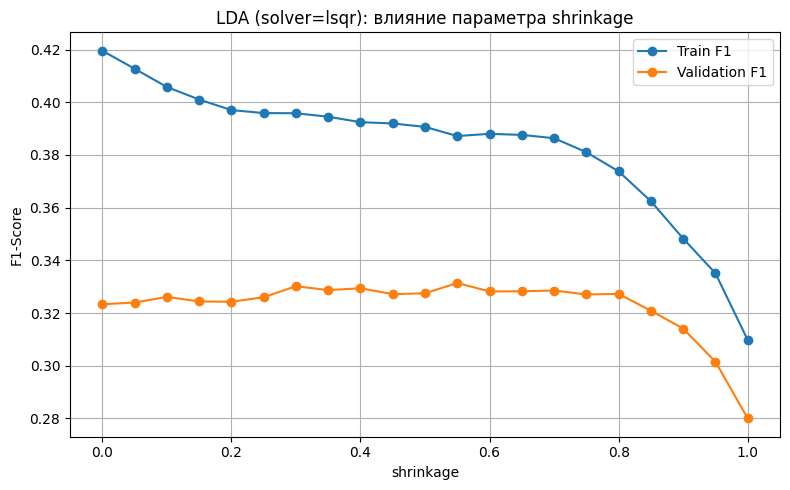

Лучшее значение shrinkage: 0.550
Настройка LDA с помощью GridSearchCV
Лучшие параметры LDA: {'classifier__shrinkage': np.float64(0.30000000000000004), 'classifier__solver': 'lsqr'}
Лучший F1 на валидации: 0.3302
[[ 29   3  44  16  11]
 [  9  11 138  32   8]
 [ 13  20 368  72  25]
 [ 19  11 191  90  35]
 [ 24   7 109  38  39]]


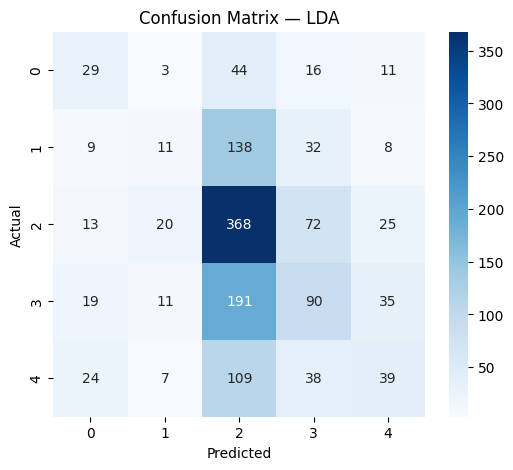

In [9]:
print("Исследование влияния shrinkage в LDA")

lda_pipe_for_val = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis(solver='lsqr'))
])

shrinkage_range = np.linspace(0.0, 1.0, 21)

train_scores, val_scores = validation_curve(
    lda_pipe_for_val, X_train, y_train,
    param_name='classifier__shrinkage',
    param_range=shrinkage_range,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(shrinkage_range, np.mean(train_scores, axis=1), 'o-', label='Train F1')
plt.plot(shrinkage_range, np.mean(val_scores, axis=1), 'o-', label='Validation F1')
plt.xlabel('shrinkage')
plt.ylabel('F1-Score')
plt.title('LDA (solver=lsqr): влияние параметра shrinkage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_shrinkage = shrinkage_range[np.argmax(np.mean(val_scores, axis=1))]
print(f"Лучшее значение shrinkage: {best_shrinkage:.3f}")


print("Настройка LDA с помощью GridSearchCV")

lda_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis())
])

param_grid_lda = [
    {'classifier__solver': ['svd']},
    {'classifier__solver': ['lsqr'], 'classifier__shrinkage': np.linspace(0.0, 1.0, 11)}
]

grid_lda = GridSearchCV(
    lda_pipe,
    param_grid_lda,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_lda.fit(X_train, y_train)

print("Лучшие параметры LDA:", grid_lda.best_params_)
print(f"Лучший F1 на валидации: {grid_lda.best_score_:.4f}")

results.append(evaluate_model(
    grid_lda.best_estimator_,
    X_train, X_test, y_train, y_test,
    'LDA'
))

## Метод опорных векторов (Support Vector Machines)
Основа: Поиск гиперплоскости, максимизирующей зазор (margin) между классами. Используются опорные векторы — граничные объекты.
С помощью ядерных функций (например, RBF, полиномиальное) SVM может строить нелинейные границы решений в расширенном пространстве.

Плюсы:

* Эффективен в пространствах высокой размерности.
* Устойчив к переобучению (при правильной регуляризации, параметр C).
* Гибкость через выбор ядра.

Минусы:
* Требует масштабирования признаков.
* Долгое обучение на больших выборках (O(n²–n³)).
* Результат чувствителен к выбору ядра и гиперпараметров (C, gamma).
* Плохо интерпретируем.

Результаты исследования параметра C:
Лучший C: 3.16e+00
Лучший F1-score (валидация): 0.3324


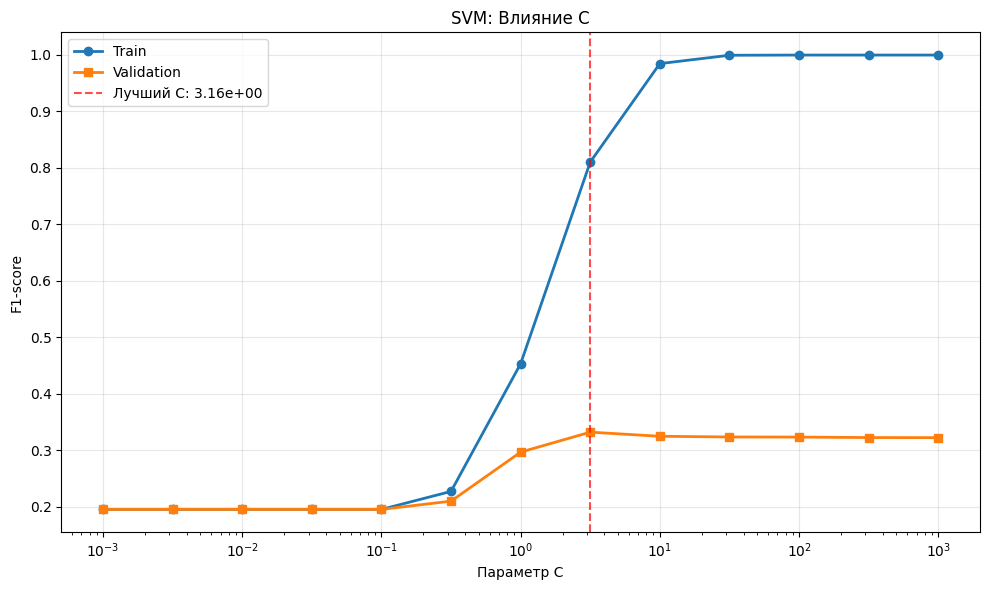


Сравнение ядер с использованием кросс-валидации:
kernel=linear: F1 = 0.3023
kernel=rbf: F1 = 0.3324
kernel=poly: F1 = 0.3328
kernel=sigmoid: F1 = 0.2786


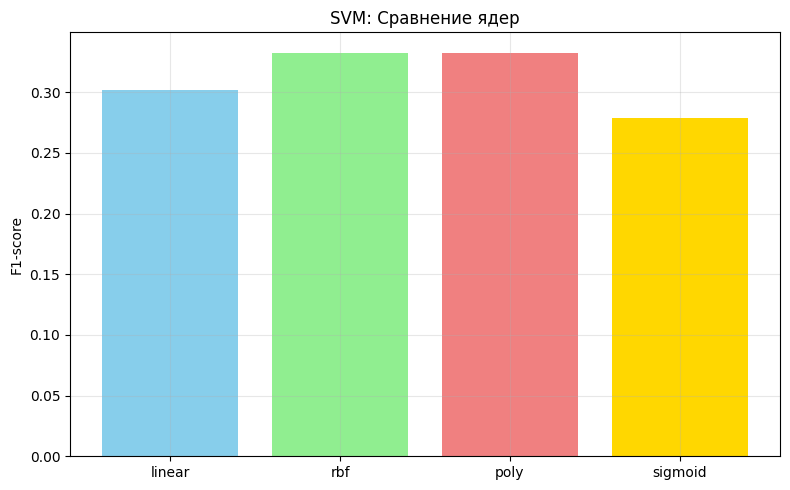


Лучшее ядро по CV: poly

Настройка степени полинома (C = 3.16e+00)
degree=2: F1 = 0.3268
degree=3: F1 = 0.3328
degree=4: F1 = 0.3347
degree=5: F1 = 0.3398
degree=6: F1 = 0.3388
Лучшая степень: 5

Финальная конфигурация SVM:
C: 3.16e+00
kernel: poly
degree: 5

Финальный F1-score на тесте: 0.3588
[[ 29   2  34  29   9]
 [  8  31 104  44  11]
 [ 17  47 296 110  28]
 [  8  24 172 119  23]
 [  8  20  97  52  40]]


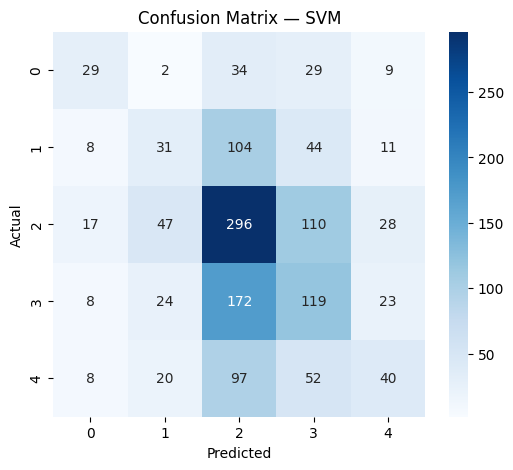

In [10]:
from sklearn.model_selection import cross_val_score
svm_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', SVC(probability=True, random_state=42))])

C_range = np.logspace(-3, 3, 13)
train_scores, val_scores = validation_curve(
    svm_pipe, X_train, y_train,
    param_name='classifier__C',
    param_range=C_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

best_idx = np.argmax(mean_val_scores)
best_C = C_range[best_idx]

print(f"Результаты исследования параметра C:")
print(f"Лучший C: {best_C:.2e}")
print(f"Лучший F1-score (валидация): {mean_val_scores[best_idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(C_range, mean_train_scores, 'o-', label='Train', linewidth=2, markersize=6)
plt.semilogx(C_range, mean_val_scores, 's-', label='Validation', linewidth=2, markersize=6)

plt.axvline(best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучший C: {best_C:.2e}')
plt.xlabel('Параметр C')
plt.ylabel('F1-score')
plt.title('SVM: Влияние C')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nСравнение ядер с использованием кросс-валидации:")
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_cv_scores = {}

for kernel in kernels:
    try:
        if kernel == 'poly':
            svm_temp = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', SVC(kernel=kernel, C=best_C, degree=3, probability=True, random_state=42))
            ])
        else:
            svm_temp = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', SVC(kernel=kernel, C=best_C, probability=True, random_state=42))
            ])
        
        scores = cross_val_score(svm_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        mean_score = scores.mean()
        std_score = scores.std()
        kernel_cv_scores[kernel] = (mean_score, std_score)
        print(f"kernel={kernel}: F1 = {mean_score:.4f}")
    except Exception as e:
        print(f"kernel={kernel}: Ошибка - {e}")
        kernel_cv_scores[kernel] = (0, 0)

plt.figure(figsize=(8, 5))
means = [kernel_cv_scores[k][0] for k in kernels]
stds = [kernel_cv_scores[k][1] for k in kernels]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar(kernels, means, color=colors, capsize=5)
plt.ylabel('F1-score')
plt.title('SVM: Сравнение ядер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_kernel = max(kernel_cv_scores, key=lambda k: kernel_cv_scores[k][0])
print(f"\nЛучшее ядро по CV: {best_kernel}")


if best_kernel == 'rbf':
    print(f"\nНастройка gamma для RBF ядра (C = {best_C:.2e})")
    
    svm_pipe_rbf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='rbf', C=best_C, probability=True, random_state=42))
    ])
    
    gamma_range = np.logspace(-3, 2, 11)
    train_scores_gamma, val_scores_gamma = validation_curve(
        svm_pipe_rbf, X_train, y_train,
        param_name='classifier__gamma',
        param_range=gamma_range,
        cv=3, scoring='f1_weighted', n_jobs=-1
    )
    
    mean_train_gamma = np.mean(train_scores_gamma, axis=1)
    mean_val_gamma = np.mean(val_scores_gamma, axis=1)
    std_val_gamma = np.std(val_scores_gamma, axis=1)
    
    best_gamma_idx = np.argmax(mean_val_gamma)
    best_gamma = gamma_range[best_gamma_idx]
    
    print(f"Лучший gamma: {best_gamma:.2e}")
    print(f"F1-score (валидация): {mean_val_gamma[best_gamma_idx]:.4f}")
    print(f"F1-score (обучение): {mean_train_gamma[best_gamma_idx]:.4f}")

    plt.figure(figsize=(10, 6))
    plt.semilogx(gamma_range, mean_train_gamma, 'o-', label='Train', linewidth=2, markersize=6)
    plt.semilogx(gamma_range, mean_val_gamma, 's-', label='Validation', linewidth=2, markersize=6)
    
    plt.fill_between(gamma_range, 
                     mean_val_gamma - std_val_gamma,
                     mean_val_gamma + std_val_gamma, 
                     alpha=0.2, color='C1')
    
    plt.axvline(best_gamma, color='red', linestyle='--', alpha=0.7, label=f'Лучший gamma: {best_gamma:.2e}')
    plt.axhline(mean_val_gamma[best_gamma_idx], color='red', linestyle='--', alpha=0.5)
    
    plt.xlabel('gamma')
    plt.ylabel('F1-score')
    plt.title('SVM: Влияние gamma (RBF ядро)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

elif best_kernel == 'poly':
    print(f"\nНастройка степени полинома (C = {best_C:.2e})")
    degrees = [2, 3, 4, 5, 6]
    degree_scores = []
    
    for degree in degrees:
        svm_temp = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', SVC(kernel='poly', C=best_C, degree=degree, probability=True, random_state=42))
        ])
        scores = cross_val_score(svm_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        degree_scores.append((scores.mean(), scores.std()))
        print(f"degree={degree}: F1 = {scores.mean():.4f}")
    
    best_degree_idx = np.argmax([s[0] for s in degree_scores])
    best_degree = degrees[best_degree_idx]
    print(f"Лучшая степень: {best_degree}")

if best_kernel == 'rbf':
    svm_final = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=best_C,
            kernel='rbf',
            gamma=best_gamma,
            probability=True,
            random_state=42
        ))
    ])
elif best_kernel == 'poly':
    svm_final = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=best_C,
            kernel='poly',
            degree=best_degree,
            probability=True,
            random_state=42
        ))
    ])
else:
    svm_final = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=best_C,
            kernel=best_kernel,
            probability=True,
            random_state=42
        ))
    ])

svm_final.fit(X_train, y_train)

y_pred_test = svm_final.predict(X_test)
final_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nФинальная конфигурация SVM:")
print(f"C: {best_C:.2e}")
print(f"kernel: {best_kernel}")
if best_kernel == 'rbf':
    print(f"gamma: {best_gamma:.2e}")
elif best_kernel == 'poly':
    print(f"degree: {best_degree}")
print(f"\nФинальный F1-score на тесте: {final_f1:.4f}")

results.append(evaluate_model(svm_final, X_train, X_test, y_train, y_test, 'SVM'))

## Метод ближайших соседей (k-Nearest Neighbors)
Основа: Принадлежность объекта определяется по голосованию среди k ближайших соседей в пространстве признаков (по расстоянию, напр. Евклидову).
Плюсы:

* Простота реализации, нет явного этапа обучения (ленивое обучение).
* Адаптивен к локальной структуре данных.
* Не делает предположений о распределении.

Минусы:

* Вычислительно затратен при предсказании (особенно на больших данных).
* Чувствителен к масштабу и шуму (требует нормализации!).
* Выбор k: маленькое k → переобучение, большое k → смещение.
* Страдает от «проклятия размерности» — расстояния теряют смысл в высоких размерностях.

Результаты исследования n_neighbors:
Лучшее k: 1
Лучший F1-score: 0.323630

Исследование различных весов:
weights='uniform': F1 = 0.323630
weights='distance': F1 = 0.323630
Лучший weights: uniform

Исследование метрик расстояния:
metric='euclidean': F1 = 0.323630
metric='manhattan': F1 = 0.322109
metric='minkowski': F1 = 0.323630
metric='chebyshev': F1 = 0.190479


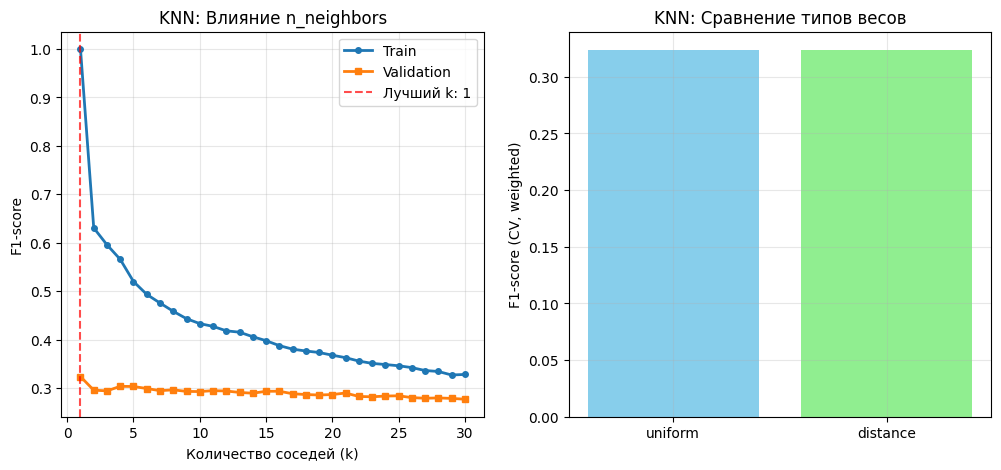

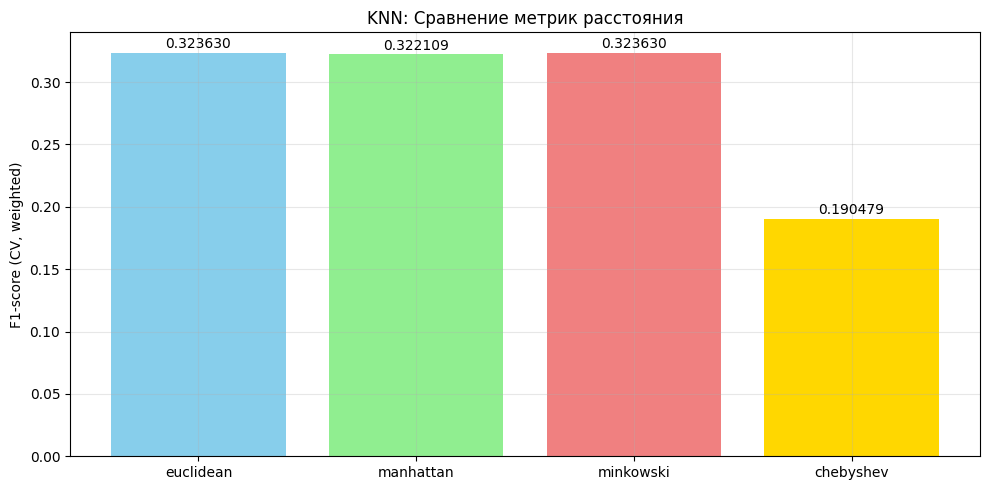

Лучшая метрика: euclidean
Финальная конфигурация k-NN:
n_neighbors = 1
weights = uniform
metric = euclidean

Финальный F1-score на тесте: 0.347739
[[ 33  12  24  22  12]
 [ 10  41  81  45  21]
 [ 29  72 238 104  55]
 [ 17  55 137 105  32]
 [ 14  32  57  55  59]]


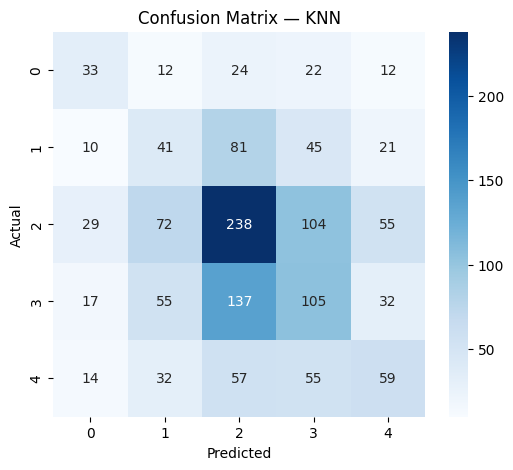

In [11]:
knn_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])

k_range = range(1, 31)
train_scores, val_scores = validation_curve(
    knn_pipe, X_train, y_train,
    param_name='classifier__n_neighbors',
    param_range=k_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)
best_idx = np.argmax(mean_val_scores)
best_k = k_range[best_idx]

print(f"Результаты исследования n_neighbors:")
print(f"Лучшее k: {best_k}")
print(f"Лучший F1-score: {mean_val_scores[best_idx]:.6f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, mean_train_scores, 'o-', label='Train', linewidth=2, markersize=4)
plt.plot(k_range, mean_val_scores, 's-', label='Validation', linewidth=2, markersize=4)
plt.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Лучший k: {best_k}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('F1-score')
plt.title('KNN: Влияние n_neighbors')
plt.legend()
plt.grid(True, alpha=0.3)


print(f"\nИсследование различных весов:")
weights = ['uniform', 'distance']
weight_results = []

for weight in weights:
    knn_temp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=best_k, 
            weights=weight
        ))
    ])
    scores = cross_val_score(knn_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    mean_f1 = scores.mean()
    weight_results.append(mean_f1)
    print(f"weights='{weight}': F1 = {mean_f1:.6f}")

best_weight_idx = np.argmax(weight_results)
best_weight = weights[best_weight_idx]
print(f"Лучший weights: {best_weight}")

plt.subplot(1, 2, 2)
plt.bar(weights, weight_results, color=['skyblue', 'lightgreen'])
plt.ylabel('F1-score (CV, weighted)')
plt.title('KNN: Сравнение типов весов')
plt.grid(True, alpha=0.3)


print(f"\nИсследование метрик расстояния:")
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
metric_results = []

for metric in metrics:
    try:
        knn_temp = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier(
                n_neighbors=best_k, 
                weights=best_weight,
                metric=metric
            ))
        ])
        scores = cross_val_score(knn_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        mean_f1 = scores.mean()
        metric_results.append(mean_f1)
        print(f"metric='{metric}': F1 = {mean_f1:.6f}")
    except Exception as e:
        print(f"metric='{metric}': Ошибка - {e}")
        metric_results.append(0)


plt.figure(figsize=(10, 5))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
bars = plt.bar(metrics, metric_results, color=colors)
plt.ylabel('F1-score (CV, weighted)')
plt.title('KNN: Сравнение метрик расстояния')
for bar, value in zip(bars, metric_results):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{value:.6f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_metric_idx = np.argmax(metric_results)
best_metric = metrics[best_metric_idx]
print(f"Лучшая метрика: {best_metric}")

if best_metric == 'minkowski':
    print(f"\nИсследование параметра p для метрики Минковского:")
    p_values = [1, 2, 3, 4, 5]
    p_results = []
    
    for p in p_values:
        knn_temp = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier(
                n_neighbors=best_k, 
                weights=best_weight,
                metric='minkowski',
                p=p
            ))
        ])
        scores = cross_val_score(knn_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        mean_f1 = scores.mean()
        p_results.append(mean_f1)
        print(f"p={p}: F1 = {mean_f1:.4f}")
    
    best_p_idx = np.argmax(p_results)
    best_p = p_values[best_p_idx]
    print(f"Лучший p: {best_p}")



if best_metric == 'minkowski':
    print(f'Финальная конфигурация k-NN:\n n_neighbors = {best_k}\nweights = {best_weight}\nmetric = {best_metric} p = {best_p}')
    knn_final = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=best_k,
            weights=best_weight,
            metric=best_metric,
            p=best_p
        ))
    ])
else:
    print(f'Финальная конфигурация k-NN:\nn_neighbors = {best_k}\nweights = {best_weight}\nmetric = {best_metric}')
    knn_final = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=best_k,
            weights=best_weight,
            metric=best_metric
        ))
    ])
knn_final.fit(X_train, y_train)

y_pred = knn_final.predict(X_test)
final_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nФинальный F1-score на тесте: {final_f1:.6f}")

results.append(evaluate_model(knn_final, X_train, X_test, y_train, y_test, 'KNN'))

## Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

hidden_layers - промежуточные слои между входом и выходом сети
* Каждый слой состоит из нейронов (например, 64 или 32).
* Чем больше слоёв и нейронов — тем сложнее зависимости может выучить модель.
* Однако избыточная сложность может привести к переобучению — когда модель запоминает обучающие данные, но плохо работает на новых.

dropout_rate - коэффициент отсева
* Dropout — это метод регуляризации, который случайно «отключает» часть нейронов во время обучения (например, 20% при dropout_rate=0.2).
* Это предотвращает переобучение: модель не может полагаться на отдельные нейроны и вынуждена учить более устойчивые признаки.
Во время предсказания все нейроны активны.

learning_rate - скорость обучения, определяющий, насколько сильно обновляются веса модели на каждом шаге обучения
* Слишком высокий (0.01 и выше) — модель может «перескакивать» оптимальное решение.
* Слишком низкий (0.0001) — обучение будет очень медленным.
* Типичное значение для оптимизатора Adam — 0.001.

bias - это дополнительный параметр в каждом нейроне, который позволяет сдвинуть его активацию независимо от входных данных.
* Без bias нейрон всегда выдавал бы 0 при нулевых входах, что сильно ограничивает гибкость модели.
* В процессе обучения bias, как и веса, подстраиваются для минимизации ошибки.

loss - это числовая мера ошибки модели на текущем этапе обучения

In [12]:
X_train_nn = preprocessor.transform(X_train)
X_test_nn = preprocessor.transform(X_test)

y_train_nn = y_train.astype(int)
y_test_nn = y_test.astype(int)

num_classes = len(np.unique(y_train_nn))
input_dim = X_train_nn.shape[1]

def create_nn_model(hidden_layers=[64, 32], dropout_rate=0.3, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

log_base_dir = "logs"
if os.path.exists(log_base_dir) and not os.path.isdir(log_base_dir):
    os.remove(log_base_dir)
os.makedirs(log_base_dir, exist_ok=True)

param_grid = {
    'hidden_layers': [[64], [128, 64], [64, 32]],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.01]
}

best_f1 = -1
best_model = None
best_history = None

print("\nПодбор гиперпараметров для нейросети")

for hidden_layers, dropout_rate, lr in product(
    param_grid['hidden_layers'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
):
    print(f"\nТестируем: layers={hidden_layers}, dropout={dropout_rate}, lr={lr}")
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_name = f"nn_hl{'_'.join(map(str, hidden_layers))}_dr{dropout_rate}_lr{lr}_{timestamp}"
    log_dir = os.path.join(log_base_dir, run_name)
    
    os.makedirs(log_dir, exist_ok=True)
    
    tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = create_nn_model(
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        learning_rate=lr
    )
    
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_test_nn, y_test_nn),
        epochs=50,
        batch_size=32,
        callbacks=[tensorboard_cb],
        verbose=0
    )
    
    y_pred_proba = model.predict(X_test_nn)
    y_pred = np.argmax(y_pred_proba, axis=1)
    f1 = f1_score(y_test_nn, y_pred, average='weighted')
    
    print(f"F1-score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_history = history
        best_params = {
            'hidden_layers': hidden_layers,
            'dropout_rate': dropout_rate,
            'learning_rate': lr
        }

y_pred_best = np.argmax(best_model.predict(X_test_nn), axis=1)
y_proba_best = best_model.predict(X_test_nn)

acc = accuracy_score(y_test_nn, y_pred_best)
prec = precision_score(y_test_nn, y_pred_best, average='weighted')
rec = recall_score(y_test_nn, y_pred_best, average='weighted')
f1 = f1_score(y_test_nn, y_pred_best, average='weighted')

y_test_bin = label_binarize(y_test_nn, classes=np.arange(num_classes))
if num_classes > 2:
    auc = roc_auc_score(y_test_bin, y_proba_best, average='weighted', multi_class='ovr')
else:
    auc = roc_auc_score(y_test_nn, y_proba_best[:, 1])

results.append({
    'Model': 'Neural Network',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
})

print("\nЛучшая нейросеть:")
print(f"Параметры: {best_params}")
print(f"F1-score на тесте: {f1:.4f}")


Подбор гиперпараметров для нейросети

Тестируем: layers=[64], dropout=0.2, lr=0.001


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} logs\nn_hl64_dr0.2_lr0.001_20251226-132140 is not a directory [Op:CreateSummaryFileWriter] name: 